# 4.2 pytorch自动求导练习
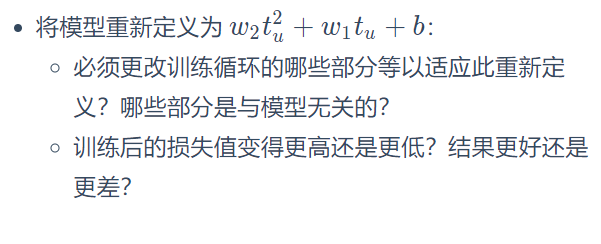

我将写下完整代码。

本练习涉及 autograd optimizer  训练集和验证集的划分  拟合与过拟合

为了更加通用,输入变量写为x ，输出变量写为y, 预测值写为p, 假设函数h(x) = w1\*x + w2\*x\*\*2  + b

In [154]:
import torch

In [155]:
# 数据集
x = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
y = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

# 转化为张量
x = torch.tensor(x)
y = torch.tensor(y)

# 特征放缩(归一化)
x = (x-x.mean())/x.std()
x

tensor([-1.0856,  0.3800,  0.4885,  1.8998,  0.0543, -0.2714, -0.8142, -1.5741,
        -0.4885,  0.2714,  1.1399])

In [156]:
# 拆分训练集和验证集

n_samples = x.shape[0]  # 总样本数
n_val = int(n_samples*0.2)  # 验证样本数

shuffled_indices =  torch.randperm(n_samples)  # 洗牌后的索引们 #indices是index的复数
train_indices = shuffled_indices[:-n_val]   
val_indices = shuffled_indices[-n_val:]
    # 这里的切分操作容易出错

train_x = x[train_indices] #训练集
train_y = y[train_indices]

val_x = x[val_indices]  # 验证集
val_y = y[val_indices]

In [157]:
# 定义模型和损失函数

def model(x,w1,w2,b):
    return w1*x + w2*x**2 + b

def loss_fn(p,y):
    squared_diffs = (p-y)**2    # squared_diffs 平方误差
    return squared_diffs.mean()  # 别忘记求.mean 。损失张量是标量型的      

In [158]:
# 定义params张量 ,参数顺序对应model模型中的 w1,w2,b

params = torch.tensor([1.,1.,0.], requires_grad=True) # 设置自动求导 

In [159]:
# 定义训练循环函数
    
def calc_forward(params,x,y,is_train):
    with torch.set_grad_enabled(is_train):  #autograd开关
        w1,w2,b=params
        p = model(x=x,w1=w1,w2=w2,b=b) # 预测张量
        loss = loss_fn(p=p,y=y) # 损失张量
    return loss
    # 计算向前传播的函数，返回loss张量，能控制autograd的开关。
        #被training_loop函数调用。 

def training_loop(n_epochs,optimizer,
                  params,train_x,train_y,val_x,val_y,
                  verbose=500):
    for epoch in range(1,n_epochs+1):
        
        # 前向传播
        train_loss = calc_forward(params=params,x=train_x,y=train_y,is_train=True)
            # 训练集的损失张量
        val_loss = calc_forward(params=params,x=val_x,y=val_y,is_train=False)
            # 验证集的损失张量
            
        optimizer.zero_grad()  #优化器统一方法。清零grad
        train_loss.backward()  # 训练损失张量上调用反向传播
        optimizer.step()       #优化器统一方法。更新权置参数
        
        if epoch % verbose == 0:
            print('Epoch %d, Train_loss %f, Val_loss %f' 
                  % (epoch,float(train_loss),float(val_loss)))
    
    return params

In [160]:
import torch.optim as optim

# 定义优化器optimizer. 采用Adam优化器
    # dir(optim) 查看所有优化器

learning_rate=1e-1
optimizer = optim.Adam(params=[params],lr=learning_rate) # 学习率自适应，该参数可以省略

In [170]:
# 调用训练循环函数
training_loop(n_epochs=5000,optimizer=optimizer,params=params,
              train_x=train_x,train_y=train_y,val_x=val_x,val_y=val_y,
              verbose=500)
# 拟合后的参数
params

Epoch 500, Train_loss 5.777016, Val_loss 21.875429
Epoch 1000, Train_loss 5.777019, Val_loss 21.874983
Epoch 1500, Train_loss 5.777013, Val_loss 21.874329
Epoch 2000, Train_loss 5.777044, Val_loss 21.892929
Epoch 2500, Train_loss 5.777017, Val_loss 21.874485
Epoch 3000, Train_loss 5.777040, Val_loss 21.891113
Epoch 3500, Train_loss 5.777021, Val_loss 21.875484
Epoch 4000, Train_loss 5.777019, Val_loss 21.875160
Epoch 4500, Train_loss 5.777018, Val_loss 21.866419
Epoch 5000, Train_loss 5.777016, Val_loss 21.874794


tensor([16.8685, -0.8296, 51.7082], requires_grad=True)

In [171]:
# 得到拟合结果
w1,w2,b=params
train_p = model(x=train_x,w1=w1,w2=w2,b=b)
val_p = model(x=val_x,w1=w1,w2=w2,b=b)

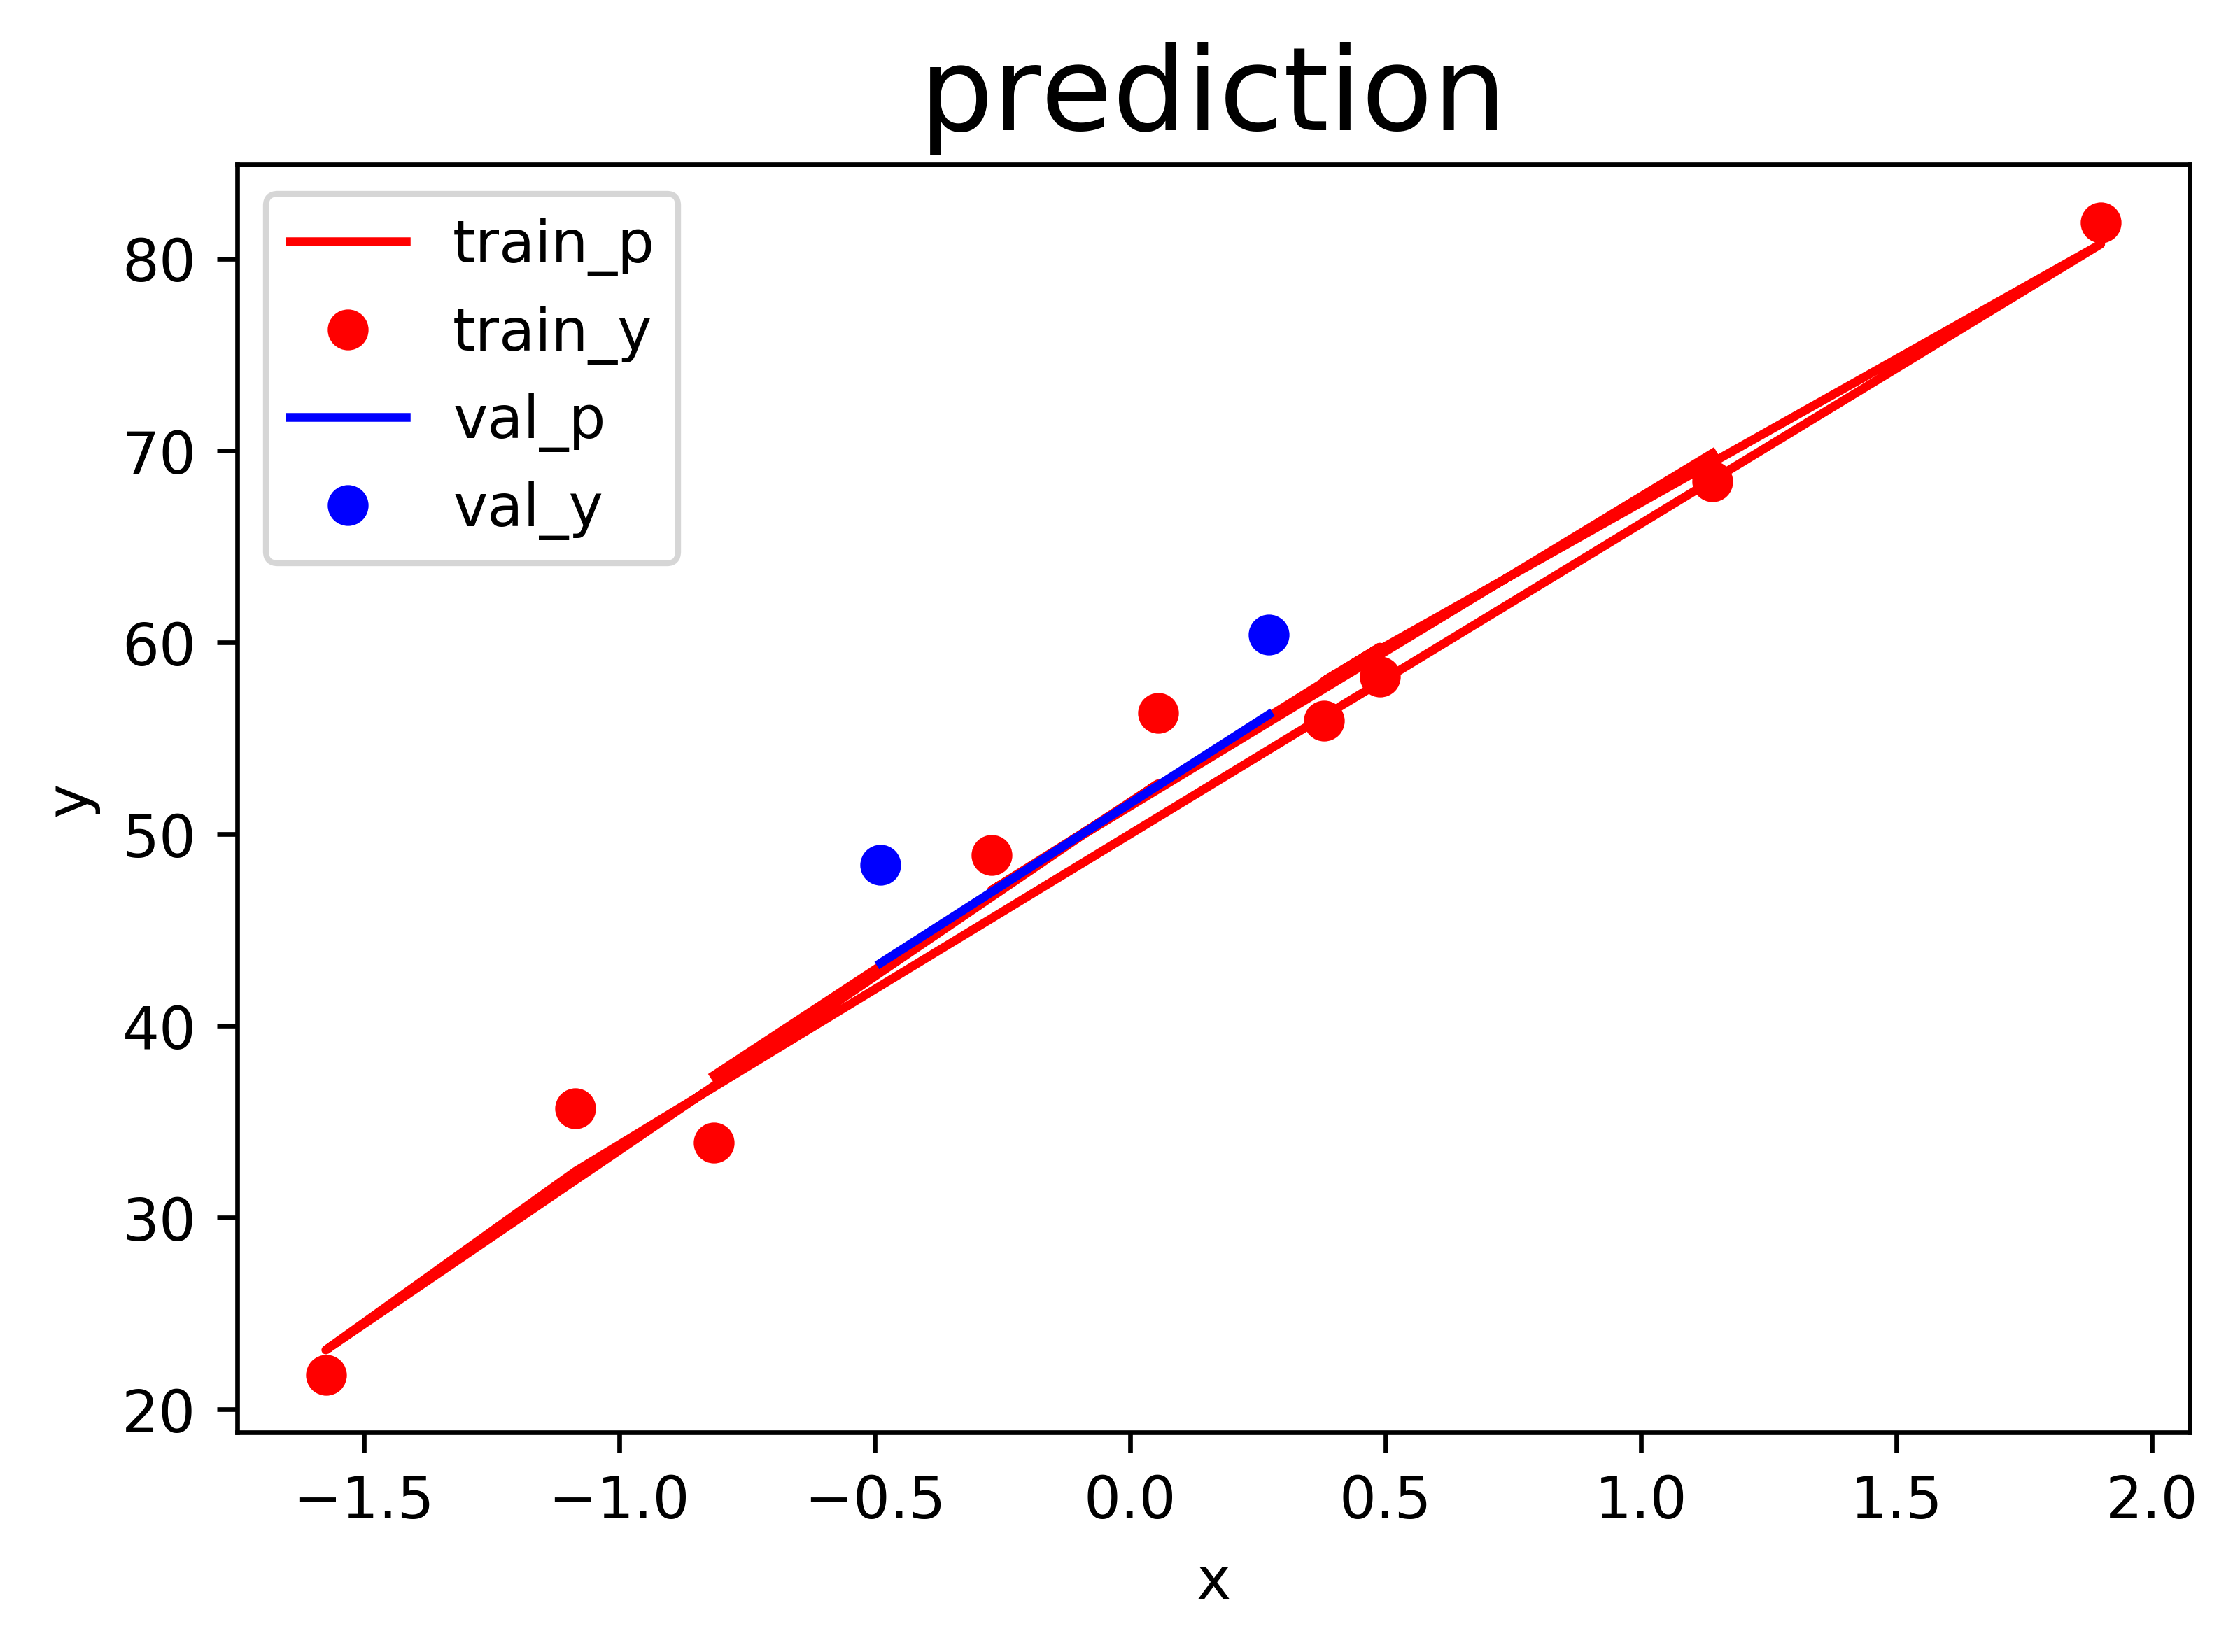

In [184]:
# 绘图
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(dpi=600)
plt.xlabel('x') # 坐标
plt.ylabel('y')
plt.title('prediction',size=20) # 标题 
plt.plot(train_x.numpy(),train_p.detach().numpy(),'r-',label='train_p') # label图例
plt.plot(train_x.numpy(),train_y.numpy(),'ro',label='train_y')
plt.plot(val_x.numpy(),val_p.detach().numpy(),'b-',label='val_p')
plt.plot(val_x.numpy(),val_y.numpy(),'bo',label='val_y')
plt.legend() # 显示图例

---

---

# 总结
- 线性模型是用于拟合数据的合理的最简单的模型；
- 凸优化技术可以用于线性模型，但不能推广到神经网络，因此本章重点介绍参数估计。
- 深度学习可用于通用模型，这些通用模型不是为解决特定任务而设计的，而是可以自动调整以专门解决眼前的问题。
- 学习算法等于根据观察结果优化模型的参数。损失函数是对执行任务中的错误的一种度量，例如预测输出值和测量值之间的误差。目标就是使损失函数值尽可能低。
- 损失函数关于模型参数的变化率可用于在减少损失的方向上更新该参数。
- PyTorch中的optim模块提供了一组现成的优化器，用于更新参数和最小化损失函数。
- 优化器使用PyTorch的autograd来计算每个参数的梯度，而梯度具体取决于该参数对最终输出的贡献程度。autograd允许用户在复杂的前向通过过程中依赖于动态计算图。
- 诸如torch.no_grad()的上下文管理器可用于控制是否需要自动求导。
- 数据通常划分为独立的训练集和验证集，从而可以在未训练的数据（即验证集）上进行模型评估。
- 当模型的性能在训练集上继续提高但在验证集上下降时，模型就发生了过拟合。这种情况通常发生在模型无法泛化（到训练集之外的数据）而是记住了训练集所需的输出时。